# CS 515 Assignment 5 - Neural Symbolic Program Synthesis with NEAR


# Mount Google Drive to access Data and Code

**Important - README** 

Before starting this assignment, please make sure that you have the `assignment5` folder uploaded to your google drive. Please rename this notebook as <your-net-id\>_assignment5.ipynb


There will be text blocks and code blocks throughout the notebook. The text blocks, such as this one, will contain instructions and questions for you to consider. The code blocks, such as the one below, will contain executable code.  Sometimes you will have to modify the code blocks following the instructions in the text blocks. You can run the code block by either pressing `control + enter` or by clicking the arrow on left-hand side of the code block.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Mount the current directory
%cd /content/drive/MyDrive/assignment5/code_and_data

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import colors
from matplotlib import rc

Mounted at /content/drive
/content/drive/MyDrive/CS515_final_project/code_and_data


# Data Exploration and Visualization

We will explore neurosymbolic models using a behavior analysis dataset. This dataset is a subset of [the Caltech Mouse Social Interactions Dataset (CalMS21)](https://https://arxiv.org/pdf/2104.02710.pdf). Neuroscientist study animal interactions to better understand the relationship between brain and behavior (see [MARS](https://elifesciences.org/articles/63720), [quantifying behavior review](https://www.nature.com/articles/s41593-020-00734-z), [decoding behavior article](https://www.quantamagazine.org/to-decode-the-brain-scientists-automate-the-study-of-behavior-20191210/)). Our goal is to map trajectory data (keypoints from two mice stacked over time `2 (mice) x 2 (x,y position) x 7 (7 keypoints per mice)`) to behaviors of interest identified by neuroscientists. The dataset consists of a pair of mice at each frame, the resident mouse in its home cage and the intruder mouse introduced to the cage.

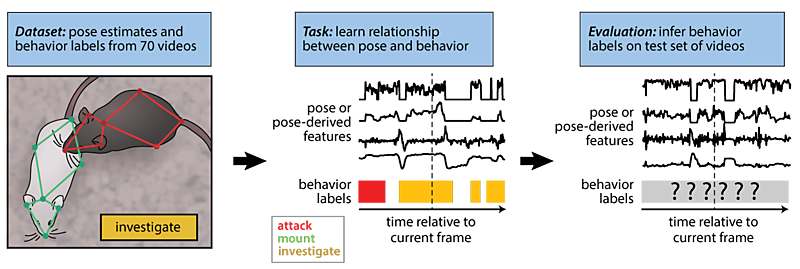

The original dataset consists of over 3 million frames of annotations, with over 10 annotated behaviors. Fully neural models are benchmarked during the [the Multi-Agent Behavior Challenge](https://www.aicrowd.com/challenges/multi-agent-behavior-representation-modeling-measurement-and-applications) which took place in 2021 in conjunction with CVPR. We use a simplified and smaller version of the dataset for this tutorial (`5000 clips x 13 frames` with one annotated behavior of `investigation`, as well as `18` pre-computed features per frame, based on features identified by behavioral neuroscientists), but if you are interested in the full Multi-Agent Behavior challenge, the evaluator at the challenge link is open and available for the full dataset. 

In this assignment, we will only use the provided data subset (5000 training clips with investigation labels only). Here, the `investigation` labels are class 1 and all other behaviors are class 0.

Final note is that instead of doing predictions sequence-by-sequence (temporal segmentation) as in the original CalMS21 dataset, here we will predict sequence-to-one labels, where we map `13` frames of trajectory data to a single human-annotated label corresponding to the behavior in the middle frame.

In [ ]:
import numpy as np

# Original mouse trajectory data in x,y coordinates
trajectory_data = np.load("data/calms21_task1/train_trajectory_data.npy")
print("Trajectory data: " + str(trajectory_data.shape))

# Processed features from trajectory data, consisting of behavior attributes
# such as speed, facing angle, distance between mice, etc.
feature_data = np.load("data/calms21_task1/train_data.npy")
print("Extracted features: " + str(feature_data.shape))

# Human annotated labels 
labels = np.load("data/calms21_task1/train_investigation_labels.npy")
print("Label data: " + str(labels.shape))

Trajectory data: (5000, 13, 2, 2, 7)
Extracted features: (5000, 13, 18)
Label data: (5000, 1)


**Exercise 1**: What is the proportion of clips that are annotated with investigation vs no investigation in the train set?

**Solution to Exercise 1:** (write down the output of your implementation below)

In [ ]:
# Your implementation here.

## Plotting utility functions

These are utility functions to help with plotting, and no modifications are needed.

In [ ]:
# Plotting utility functions.
 
rc('animation', html='jshtml')
  
#Plotting constants
FRAME_WIDTH_TOP = 1024
FRAME_HEIGHT_TOP = 570
 
RESIDENT_COLOR = 'lawngreen'
INTRUDER_COLOR = 'skyblue'
 
PLOT_MOUSE_START_END = [(0, 1), (0, 2), (1, 3), (2, 3), (3, 4),
                        (3, 5), (4, 6), (5, 6), (1, 2)]
  
def set_figax():
    fig = plt.figure(figsize=(6, 4))
 
    img = np.zeros((FRAME_HEIGHT_TOP, FRAME_WIDTH_TOP, 3))
 
    ax = fig.add_subplot(111)
    ax.imshow(img)
 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
 
    return fig, ax
 
def plot_mouse(ax, pose, color):
    # Draw each keypoint
    for j in range(7):
        ax.plot(pose[j, 0], pose[j, 1], 'o', color=color, markersize=5)
 
    # Draw a line for each point pair to form the shape of the mouse
 
    for pair in PLOT_MOUSE_START_END:
        line_to_plot = pose[pair, :]
        ax.plot(line_to_plot[:, 0], line_to_plot[
                :, 1], color=color, linewidth=1)
 
def animate_pose_sequence(video_name, keypoint_sequence):
    # Returns the animation of the keypoint sequence between start frame
    # and stop frame. Optionally can display annotations.
    seq = keypoint_sequence.transpose((0,1,3,2))
 
    image_list = []
    
    counter = 0
    for j in range(keypoint_sequence.shape[0]):
        if counter%20 == 0:
          print("Processing frame ", j)
        fig, ax = set_figax()
        plot_mouse(ax, seq[j, 0, :, :], color=RESIDENT_COLOR)
        plot_mouse(ax, seq[j, 1, :, :], color=INTRUDER_COLOR)
         
        ax.set_title(
            video_name + '\n frame {:03d}.png'.format(j), fontsize = 14)
 
        ax.axis('off')
        fig.tight_layout(pad=1)
        ax.margins(0)
 
        fig.canvas.draw()
        image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(),
                                        dtype=np.uint8)
        image_from_plot = image_from_plot.reshape(
            fig.canvas.get_width_height()[::-1] + (3,)) 
 
        image_list.append(image_from_plot)
 
        plt.close()
        counter = counter + 1
 
    # Plot animation.
    fig = plt.figure()
    plt.axis('off')
    im = plt.imshow(image_list[0])
 
    def animate(k):
        im.set_array(image_list[k])
        return im,
    ani = animation.FuncAnimation(fig, animate, frames=len(image_list), blit=True)
    return ani
 

## Plot a trajectory sample that is not annotated with investigation

This corresponds to a sample in class 0.



Processing frame  0


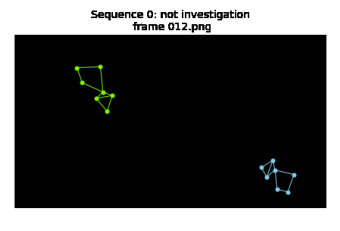

In [ ]:
# Plot the first example of class 0 = not investigation

total_samples = labels.shape[0]

for i in range(total_samples):
  if labels[i] == 0:
    ani = animate_pose_sequence('Sequence ' + str(i) + ': not investigation', trajectory_data[i])
    break
ani

## Plot a trajectory sample that is annotated with investigation

This corresponds to a sample in class 1.

Processing frame  0


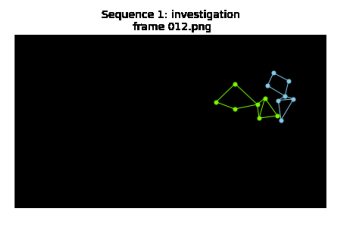

In [ ]:
# Plot the first example of class 1 = investigation

for i in range(total_samples):
  if labels[i] == 1:
    ani = animate_pose_sequence('Sequence ' + str(i) + ': investigation', trajectory_data[i])
    break
ani

## Plot examples with feature values

In behavior analysis (similar to other fields of science), we often already have existing domain knowledge available. Here, we use existing features designed by neuroscientists for studying behavior (see [Mouse Action Recognition System](https://elifesciences.org/articles/63720)) instead of the raw trajectory data. These manually-designed features can be used as inputs to neural networks or as part of a Domain-Specific Language (more on this below).

In [ ]:
# Feature value plotting utilities

def set_figax_features():
    fig = plt.figure(figsize=(6,6))
 
    img = np.zeros((FRAME_HEIGHT_TOP, FRAME_WIDTH_TOP, 3))
 
    ax = fig.add_subplot(211)
    ax.imshow(img)
 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
 
    ax2 = fig.add_subplot(212)

    return fig, ax, ax2

def animate_pose_sequence_features(video_name, keypoint_sequence, feature_sequence,
                                   max_y_lim = None, min_y_lim = None):
    # Returns the animation of the keypoint sequence between start frame
    # and stop frame. Optionally can display annotations.
    seq = keypoint_sequence.transpose((0,1,3,2))
 
    image_list = []
    
    counter = 0
    for j in range(keypoint_sequence.shape[0]):
        if counter%20 == 0:
          print("Processing frame ", j)
        fig, ax, ax2 = set_figax_features()
        plot_mouse(ax, seq[j, 0, :, :], color=RESIDENT_COLOR)
        plot_mouse(ax, seq[j, 1, :, :], color=INTRUDER_COLOR)
         
        ax.set_title(
            video_name + '\n frame {:03d}.png'.format(j), fontsize = 14)
 
        ax.axis('off')
        fig.tight_layout(pad=1)
        ax.margins(0)

        ax2.plot(np.arange(feature_sequence.shape[0]), feature_sequence)
        ax2.set_ylim([min_y_lim, max_y_lim])

        ax2.vlines(x = j, ymin = -100, ymax = 100,
                  colors = 'salmon', linestyles = 'dashed')

        fig.canvas.draw()
        image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(),
                                        dtype=np.uint8)
        image_from_plot = image_from_plot.reshape(
            fig.canvas.get_width_height()[::-1] + (3,)) 
 
        image_list.append(image_from_plot)
 
        plt.close()
        counter = counter + 1
 
    # Plot animation.
    fig = plt.figure()
    plt.axis('off')
    plt.tight_layout()
    im = plt.imshow(image_list[0])
 
    def animate(k):
        im.set_array(image_list[k])
        return im,
    ani = animation.FuncAnimation(fig, animate, frames=len(image_list), blit=True)
    return ani


**Exercise 2**: Modify the code below to plot some other samples and features - note that some feature subsets have more than one feature (ex: axis ratio has 2 features for the ratio between the long and short axis of the body for the resident and intruder mouse respectively). Is there a feature that can more easily distinguish between `not investigation` and `investigation`?

**Solution to Exercise 2:** (please write your answer here)


Processing frame  0


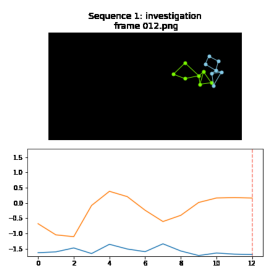

In [ ]:
from IPython.display import HTML, Image # For GIF


# Plot the first example of class 1 = investigation with features
# Note that feature values are already normalized
CALMS21_FEATURE_SUBSETS = {
    "res_angle_head_body": np.arange(0, 2),
    "axis_ratio": np.arange(2, 4),
    "speed": np.arange(4, 6),
    "acceleration": np.arange(6, 8),
    "tangential_velocity": np.arange(8, 10),
    "rel_angle_social": np.arange(10, 12),
    "angle_between": np.arange(12, 13),
    "facing_angle": np.arange(13, 15),
    "overlap_bboxes": np.arange(15, 16),
    "area_ellipse_ratio": np.arange(16, 17),
    "min_res_nose_dist": np.arange(17, 18)
}

# Change the feature name in the dictionary here to plot different features.
feature_indices = CALMS21_FEATURE_SUBSETS['rel_angle_social'].squeeze()

# Modify the code below to plot different samples.
for i in range(total_samples):
  if labels[i] == 1:
    ani = animate_pose_sequence_features('Sequence ' + str(i) + ': investigation', 
                                         trajectory_data[i], 
                                         feature_data[i, :, feature_indices].transpose(),
                                         max_y_lim = np.max(feature_data[:, :, feature_indices]),
                                         min_y_lim = np.min(feature_data[:, :, feature_indices]))
    break

ani

# Neural Network Example (1D Conv Net)

One common way to train a neural network for sequence-to-one predictions is by using a 1D convolutional network (across the temporal dimension). We use the [Conv1D](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html) implementation in Pytorch, within the Pytorch Lightning framework (a wrapper on top of Pytorch to simplify the code for training and data loading). Try going through the code below to familiarize yourself with training the 1D conv net below to get performance values of fully neural models on this dataset.

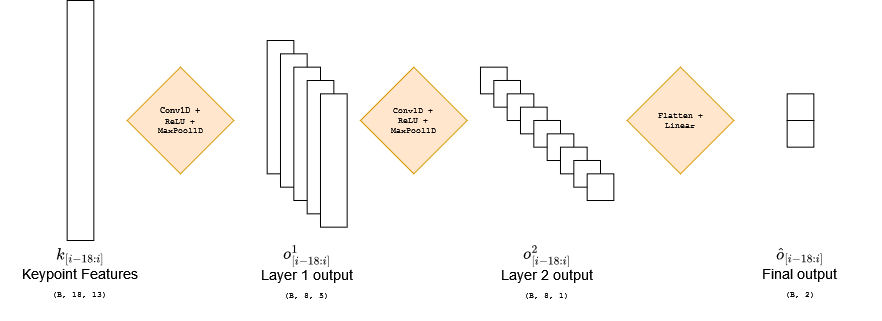

Important setups for the neural network training:
*   `TrainConfig`: defines hyperparameters for training
*   `Calms21Task1Dataset` and `Calms21Task1DataModule`: contains train, validation, and test dataloaders for training and evaluation. The dataloader outputs batched data for mini batch gradient descent.
*   `ConvNet1DBaseline`: defines the model architecture (1D Conv Net) with network weights updated during training using the Adam optimizer.

In [ ]:
!pip install pytorch-lightning==1.8.2 # Pytorch lightning is a wrapper around PyTorch.
import os
import torch, numpy as np
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from sklearn.metrics import f1_score, precision_score, recall_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 798 kB 12.0 MB/s 
     |████████████████████████████████| 529 kB 53.7 MB/s 
     |████████████████████████████████| 87 kB 9.0 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115940 sha256=b9fa4f188e2f444180c100fa2b486da8689bfa3beee322700c6ff3e459ac7e8e
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire


The two cells below contain code to set up the training config and the data loader for the CalMS21 dataset.

In [ ]:
# Feel free to play around with these numbers at any time. Here's how to modify the numbers
# config = TrainConfig()
# config.epochs = 100 
class TrainConfig:
    epochs: int = 20
    batch_size: int = 32
    lr: float = 3e-3
    weight_decay: float = 0.0
    train_size: int = 2000 # out of 5000
    val_size: int = 1000 # out of 5000
    test_size: int = 3000 # out of 3000
    num_classes: int = 2

config = TrainConfig()

In [ ]:
# Dataloader for the CalMS21 dataset
class Calms21Task1Dataset(torch.utils.data.Dataset):
    def __init__(self, data_path, investigations_path, transform=None, target_transform=None):
        self.data = np.load(data_path)
        self.investigations = np.load(investigations_path)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.investigations[idx]
        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            y = self.target_transform(y)
        return x, y


class Calms21Task1DataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size, transform=None, target_transform=None ):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.train_data_path = os.path.join(data_dir, "train_data.npy")
        self.train_investigations_path = os.path.join(data_dir, "train_investigation_labels.npy")
        self.test_data_path = os.path.join(data_dir, "test_data.npy")
        self.test_investigations_path = os.path.join(data_dir, "test_investigation_labels.npy")
        self.val_data_path = os.path.join(data_dir, "val_data.npy")
        self.val_investigations_path = os.path.join(data_dir, "val_investigation_labels.npy")
        self.transform = transform
        self.target_transform = target_transform

    def setup(self, stage=None):
        self.train_dataset = Calms21Task1Dataset(self.train_data_path, self.train_investigations_path, self.transform, self.target_transform)
        self.val_dataset = Calms21Task1Dataset(self.val_data_path, self.val_investigations_path, self.transform, self.target_transform)
        self.test_dataset = Calms21Task1Dataset(self.test_data_path, self.test_investigations_path, self.transform, self.target_transform)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
    
    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)
    
    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)

dm = Calms21Task1DataModule(data_dir="data/calms21_task1/", batch_size=32, transform=None, target_transform=None)
dm.setup(None)
test_dataloader = dm.test_dataloader()


## Training Utilities for 1D Conv Net

In [ ]:
from collections import OrderedDict
class ConvNet1DBaseline(pl.LightningModule):
    # Convert above keras function to pytorch
    def __init__(self, config : TrainConfig):
        super().__init__()
        self.config = config
        self.channels = (8, 8)
        # input_dim = (batch_size, 18, 13)
        self.model = nn.Sequential(OrderedDict([
            ('block1', self.init_block(18, self.channels[0])),
            ('block2', self.init_block(self.channels[0], self.channels[1])),
            ('flatten', nn.Flatten()),
            ('dense1', nn.Linear(self.channels[0], config.num_classes)),
        ]))
        
    def init_block(self, input_size, output_size, kernel_size=3) -> nn.Sequential:
        return nn.Sequential(OrderedDict([
            ('conv', nn.Conv1d(input_size, output_size, kernel_size=kernel_size, stride=1, padding=0)),
            ('bn', nn.BatchNorm1d(output_size)),
            ('act', nn.ReLU()),
            ('maxpool', nn.MaxPool1d(2, 2)),
            ('dropout', nn.Dropout(0.5)),
        ]))
        

    def forward(self, x):
        """
        x : (batch_size, 18, 13)
        output : (batch_size, num_classes)
        """
        output = self.model(x.transpose(-1, -2))
        return output
    
    def f1_score(self, y_true, y_pred):
        """
        y_true : (batch_size, num_classes)
        y_pred : (batch_size, num_classes)
        """
        y_true = y_true.cpu().numpy()
        y_pred = y_pred.cpu().numpy()
        return f1_score(y_true, y_pred, average="binary")

    def step(self, batch, stage=None):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y.squeeze(1))


        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log(f"{stage}_acc", torch.eq(y_hat.argmax(-1), y).float().mean())
            self.log(f"{stage}_f1", self.f1_score(y, y_hat.argmax(-1)), prog_bar=True)

        return loss
    
    def training_step(self, batch, batch_idx):
        nll_loss = self.step(batch, stage=None)
        self.log("train_loss", nll_loss)
        return nll_loss

    def validation_step(self, batch, batch_idx):
        self.step(batch, stage="valid")

    def test_step(self, batch, batch_idx):
        self.step(batch, stage="test")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),
            lr=self.config.lr,
            weight_decay=self.config.weight_decay
        )
        return optimizer


model = ConvNet1DBaseline(config=config)

## Run Training 

After running training below once, note the F1 score from evaluation. [F1 score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) is the harmonic mean of precision and recall and is a common metric used in classification tasks.

In [ ]:
def train(model, datamodule, config):
    trainer = pl.Trainer(gpus=0, max_epochs=config.epochs)
    trainer.fit(model, datamodule)
    return model

trained_model = train(model, dm, config=config)


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/setup.py:178: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type       | Params
----

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
# Evaluate using F1 score.
test_trajectory = np.load("data/calms21_task1/test_trajectory_data.npy")
test_labels = np.load("data/calms21_task1/test_investigation_labels.npy")

def evaluate(model, data_loader, gt_labels):
  predictions = []
  for x,_ in data_loader:
    predictions.append(torch.argmax(model(x), dim = -1))

  predictions = torch.cat(predictions, dim = 0)

  f1 = f1_score(test_labels, predictions, average="binary")
  precision = precision_score(test_labels, predictions, average="binary")
  recall = recall_score(test_labels, predictions, average="binary")

  print("F1 score on test set: " + str(f1))
  print("Precision on test set: " + str(precision))
  print("Recall on test set: " + str(recall))

  return predictions, f1, precision, recall


predictions_nn, _, _, _ = evaluate(model, dm.test_dataloader(), test_labels)

F1 score on test set: 0.7312986235786955
Precision on test set: 0.6424815983175605
Recall on test set: 0.8486111111111111


## Display samples from each class, middle frame is shown

**Exercise 3**: Use the 2 code cells below to plot some correctly and incorrectly classified examples. Do you see anything in common between the examples in each class? What are some possible features that might be helpful for distinguishing `investigation` and `no investigation`?

**Solution to Exercise 3:** (please write your answer here)

In [ ]:
def display_samples_by_class(trajectory_data, class_labels, predicted_classes, 
                             num_classes = 2, n_samples = 5):
  seq = trajectory_data.transpose((0,1,2,4,3))

  fig, axs = plt.subplots(n_samples, num_classes*2, 
                          figsize = (n_samples*6, num_classes*2*6))

  img = np.zeros((FRAME_HEIGHT_TOP, FRAME_WIDTH_TOP, 3))

  for c in range(num_classes):
    for predicted in range(num_classes):
      # This only works for 2 classes
      plot_id = c*2 + abs(predicted - c)
      if predicted == c:
        axs[0][plot_id].set_title('Class ' + str(c) + 
                            '- Predicted ' + str(predicted), color = 'green', fontsize = 28)
      else:
        axs[0][plot_id].set_title('Class ' + str(c) + 
                            '- Predicted ' + str(predicted), color = 'red', fontsize = 28)  

      gt = np.argwhere(class_labels.squeeze() == c).squeeze()
      pred = np.argwhere(predicted_classes.squeeze() == predicted).squeeze()

      random_indices = np.random.choice(np.intersect1d(gt, pred), 
                                        size=n_samples, replace=False)

      for i in range(random_indices.shape[0]):

        axs[i][plot_id].imshow(img)

        plot_mouse(axs[i][plot_id], seq[random_indices[i], 6, 0, :, :], color=RESIDENT_COLOR)
        plot_mouse(axs[i][plot_id], seq[random_indices[i], 6, 1, :, :], color=INTRUDER_COLOR)

        axs[i][plot_id].text(50, 100, 'Test ID: ' + str(random_indices[i]), fontsize=28, color='C1')

        axs[i][plot_id].axis('off')
        fig.tight_layout(pad=1)
        axs[i][plot_id].margins(0)

  return fig


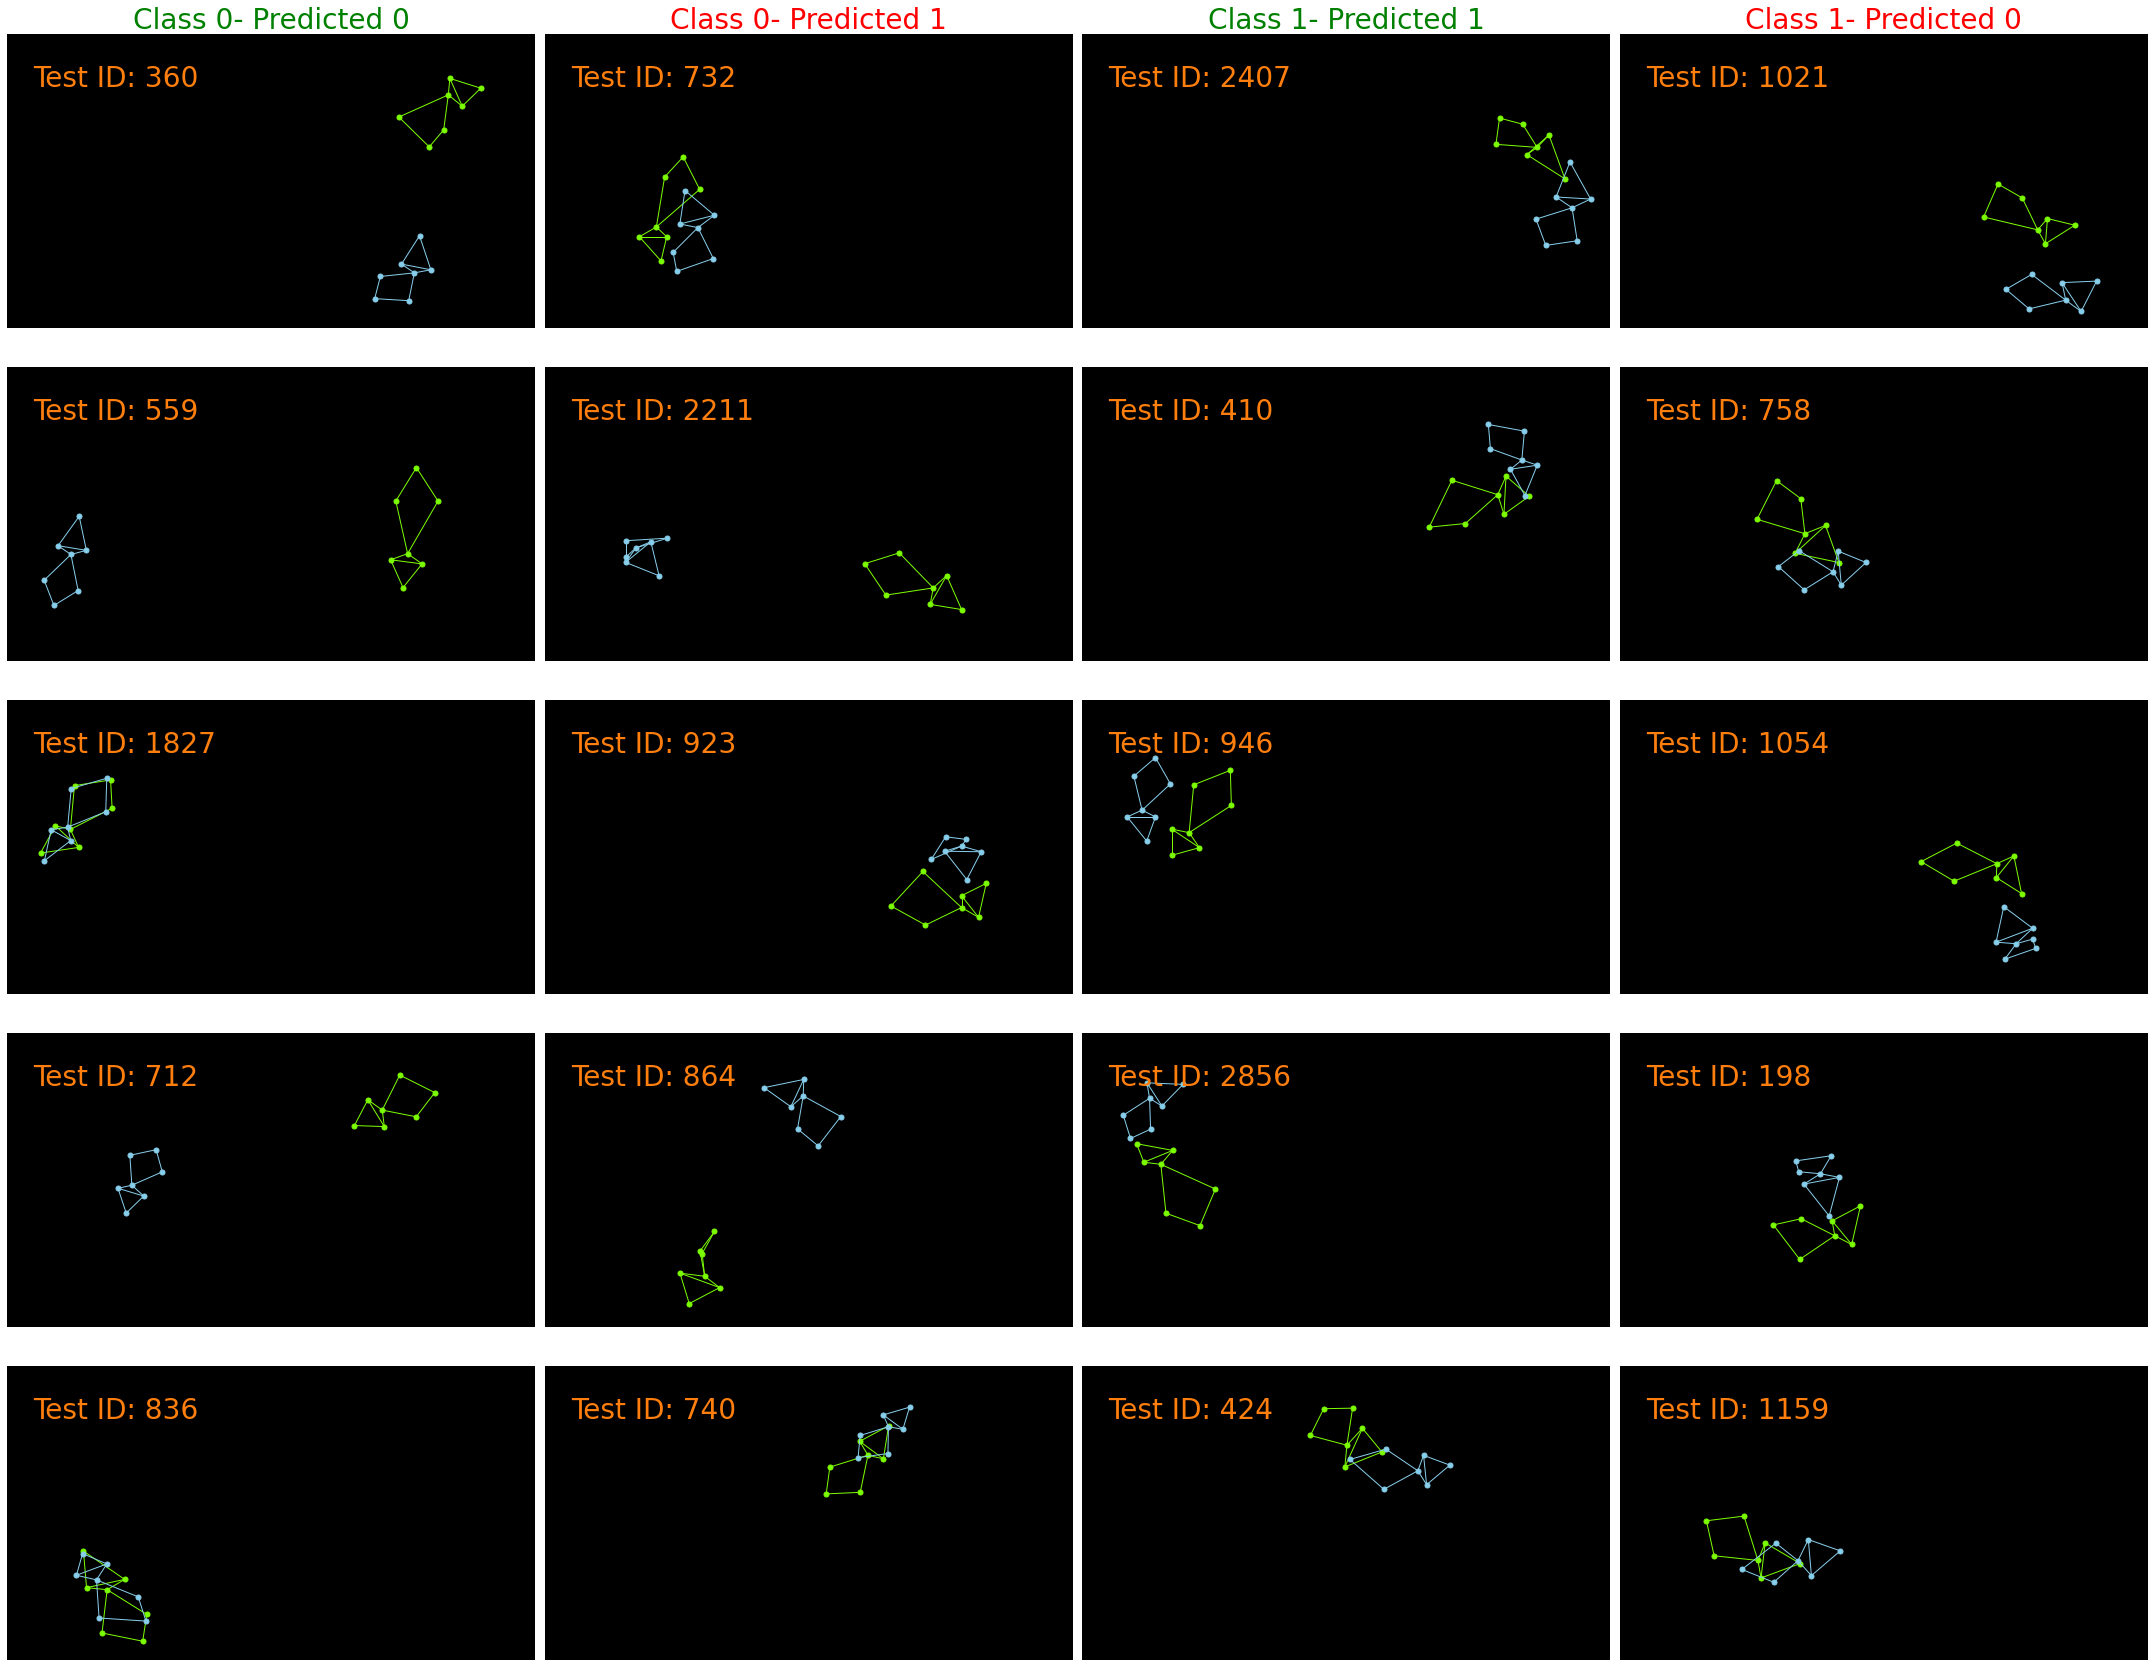

In [ ]:
fig = display_samples_by_class(test_trajectory, test_labels, predictions_nn)
plt.show(fig)

# Program Optimization and DSL Example

Let's try to hand engineer program structures to solve this task! After specifying program structure, we update program parameters using gradient descent and Pytorch. This is possible because our programs are differentiable. We'll be writing programs in the language specified below:

Selectors (`atom -> atom`): 
* `ResAngleHeadBodySelect`: angle formed by the left/right ear, neck and left/right hip keypoints on the resident mouse.
* `SpeedSelect`: mean change in position of centroids, computed across two consecutive frames for resident and intruder moouse.
* `TangentialVelocitySelect`: component of the mouse’s centroid velocity tangential to the vector between the centroids of the two mice, computed across two consecutive frames, for resident and intruder mouse.
* `AccelerationSelect`: mean change in speed of centroids computed across two consecutive frames for resident and intruder mouse.
* `RelAngleSocialSelect`: relative angle between the body of the mouse (ori_body) and the line connecting the centroids of both mice, computed for resident and intruder mouse. 
* `AxisRatioSelect`:	major_axis_len/minor_axis_len of an ellipse fit to the pose of each mice.
* `OverlapBboxesSelect`: intersection over union of the bounding boxes of the two mice.	
* `MinResNoseKeypointDistSelect`: The minimum over all distances from the resident nose to any intruder keypoints.

Operators (`atom -> atom`):
* `Or(fn1, fn2)` : Adding output logits from two programs.
* `And(fn1, fn2)` : Multiplying output logits from two programs.

Aggregators (`List[atom] -> atom`):
* `Window5Avg` : `current_prediction = avg(pred[i-2:i]+ pred[i] + pred[i:i+2])`
* `Window7Avg` : `current_prediction = avg(pred[i-3:i]+ pred[i] + pred[i:i+3])`
* `Window13Avg` : `current_prediction = avg(pred[i-6:i]+ pred[i] + pred[i:i+6])`


Sample program:

`Window5Avg( Or(AccelerationSelect, OverlapBboxesSelect) )` will calculate the acceleration and the bounding box overlap of the resident and intruder mice and use the running average across 5 frames in the input to predict whether the resident mouse is investigating or not. In general, the innermost functions are executed first and are used as inputs to the outer functions.

In [ ]:
from dsl_compiler import ExpertProgram

program = "Window5Avg( Or(AccelerationSelect, OverlapBboxesSelect) )"
config.lr = 1e-2
sample_model = ExpertProgram(program, config=config)

# Use gradient descent to find parameters of multi-variable linear regression.
sample_model = train(sample_model, dm, config=config)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/setup.py:178: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type | Params
-----------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
# Evaluate using F1 score.

predictions_nn, _, _, _ = evaluate(sample_model, dm.test_dataloader(), test_labels)

F1 score on test set: 0.3916376306620209
Precision on test set: 0.393006993006993
Recall on test set: 0.3902777777777778


**Exercise 4**: Can you find feature combinations that work better than the sample program? How does your hand-crafted program compare to the 1D Conv Net in terms of F1 score?

**Solution to Exercise 4:** (please evaluate your program using the code block below and compare the comperformance with the sample program and 1D Conv Net in terms of F1 score)

**Hint**: Based on the trajectory visualizations with features above, is there a feature that can discriminate between investigation and no investigation better than the provided sample program? 

In [ ]:
program = 'Write your program string here'
config.lr = 1e-2
expert_model = ExpertProgram(program, config=config)

# Use gradient descent to find parameters of multi-variable linear regression.
custom_model = train(expert_model, dm, config=config)

predictions_nn, _, _, _ = evaluate(custom_model, dm.test_dataloader(), test_labels)

AssertionError: ignored

# Visualizing 1D Conv Net and Programs 

**Exercise 5**: We visualize the weights of part of the 1D Conv Net as well as from the optimized programs. How does the number of parameters compare from neural nets such as 1D Conv Nets to programs?


**Solution to Exercise 5:** (please write your answer here)

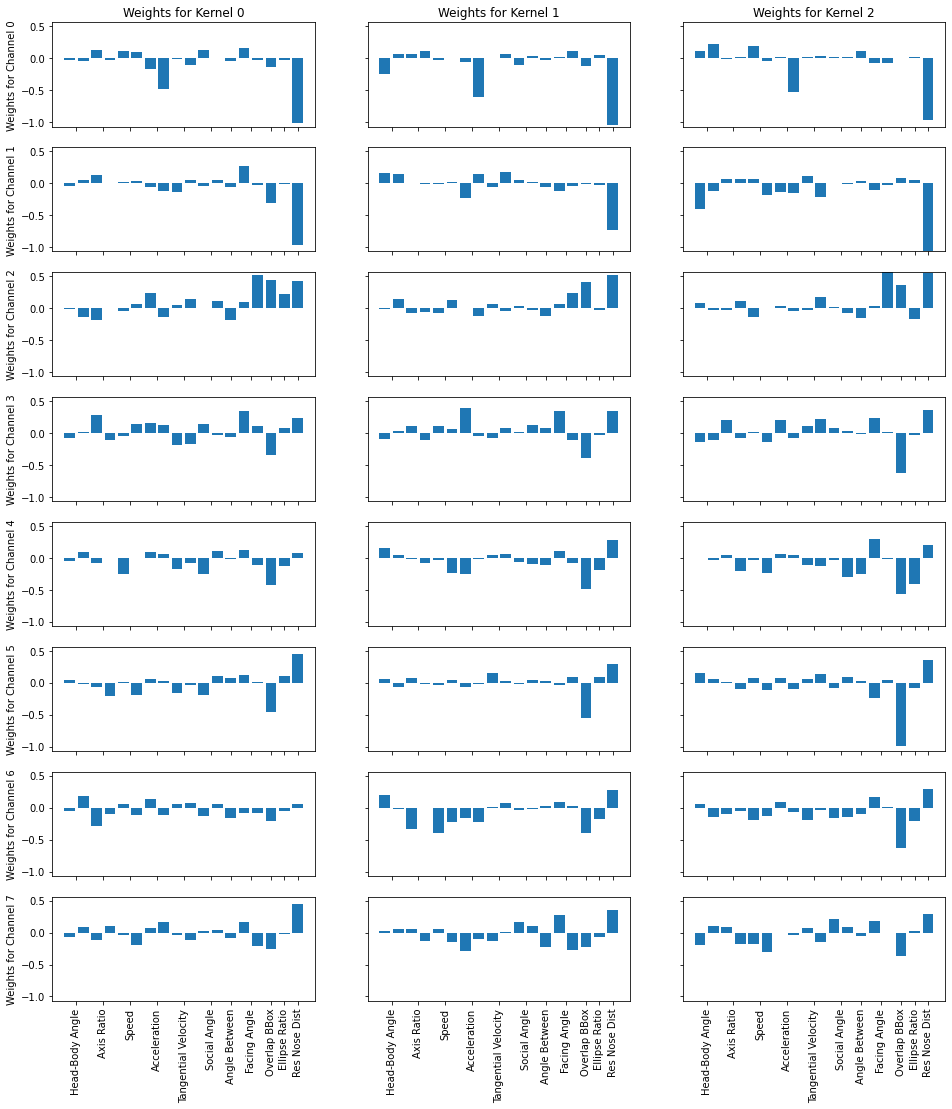

In [ ]:
layer_to_plot = 'block1.conv.weight' # We plot one of the conv layers

for name, param in trained_model.model.named_parameters():
  if name == layer_to_plot:
    param = param.detach().numpy()
    num_channels, num_features, num_kernels = param.shape

    max_val = np.max(param)
    min_val = np.min(param)    
    
    fig, axs = plt.subplots(num_channels, num_kernels, 
                            figsize = (num_channels*2, num_kernels*6), 
                            sharex = True, sharey = True)
    
    for i in range(num_channels):
      axs[i][0].set_ylabel('Weights for Channel ' + str(i))

      for j in range(num_kernels):
        axs[i][j].bar(range(num_features), param[i, :, j])
        axs[i][j].set_ylim([min_val, max_val])

    for j in range(num_kernels):
      axs[0][j].set_title('Weights for Kernel ' + str(j))
      axs[-1][j].set_xticks([0.5,2.5,4.5,6.5,8.5,10.5,12,13.5,15,16, 17])
      axs[-1][j].set_xticklabels(["Head-Body Angle", "Axis Ratio", "Speed",
                                  "Acceleration", "Tangential Velocity", 
                                  "Social Angle", "Angle Between", "Facing Angle",
                                  "Overlap BBox", "Ellipse Ratio", "Res Nose Dist"],
                                 rotation = 90) 
      


In [ ]:
# Print program

from near import print_program

print(print_program(sample_model.model, ignore_constants = False))


Window5Avg(Or(AccelerationSelect(params: dict_values([Parameter containing:
tensor([[ 0.0025,  0.0524],
        [-0.2427, -0.1128]], requires_grad=True), Parameter containing:
tensor([0.2772, 0.4438], requires_grad=True)])), OverlapBboxesSelect(params: dict_values([Parameter containing:
tensor([[-0.2582],
        [ 0.8855]], requires_grad=True), Parameter containing:
tensor([ 0.5217, -0.4977], requires_grad=True)]))))


# Exercise 6: Open-Ended Exploration

Can you improve the performance of your own hand-designed programs?

*     Try improving your own program within the provided DSL and see how your optimized programs compare to the 1D Conv Net performance! How do different program architecture choices affect performance?

**Answer to Exercise 6:** (Write programs you have tried and what's their performance)

In the following part of this assignment, we will show you ways of automatically performing program architecture search from the DSL without manually designing program structures as we do in this notebook.

# (Important!) Convert Notebooks to Python Files

If you update the DSL in `dsl.ipynb` or the search algorithm in `near.ipynb`, you need to run this cell again to update the code in this notebook.


In [ ]:
!jupyter nbconvert --to python dsl.ipynb
!jupyter nbconvert --to python near.ipynb

[NbConvertApp] Converting notebook dsl.ipynb to python
[NbConvertApp] Writing 41558 bytes to dsl.py
[NbConvertApp] Converting notebook near.ipynb to python
[NbConvertApp] Writing 39669 bytes to near.py


# Search Tree Visualization

The Domain-Specific Languages we use for behavior analysis are in `dsl.ipynb`. Through this notebook, you will be training enumeration algorithms to search through the space of programs defined by this DSL, and there will also be exercises to modify the DSL to improve program performance.

See the figure below for a visualization of the search tree using an example DSL.

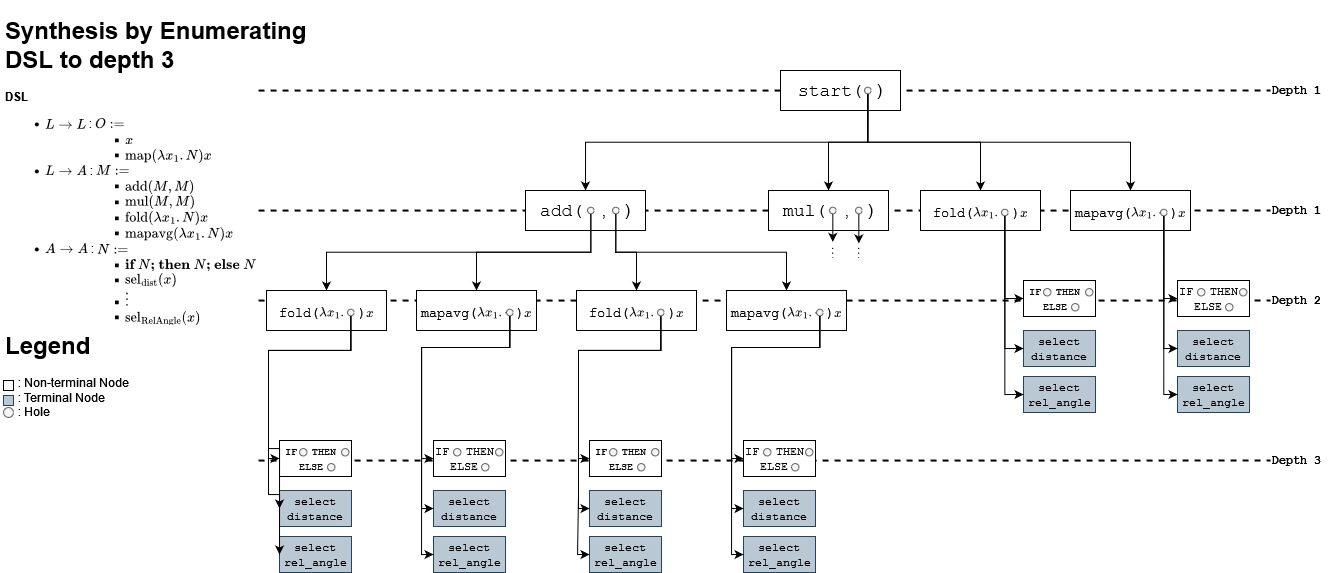

# Enumeration: Base DSL

The enumeration algorithm will enumerate through all symbolic programs until `max_num_programs` is reached. Since the number of programs at each depth may be large, the argument `max_num_programs` limits the total number of programs we train.

We start with enumerating 25 programs (which enables us to search up to depth 5) using a basic DSL. 

**Exercise 7:** Looking at the results printed at the end, do you observe anything common or different across program structures for the best and worst programs?

Note that: 
*     `score` = 1 - F1 Score
*     `struct_cost` = cost of program structure (more complex programs have higher structural costs)
*     `path_cost` = score + struct_cost


**Solution to Exercise 7:** (please write your observation here)

In [ ]:
!yes | python train.py \
--algorithm enumeration \
--exp_name investigation_base \
--trial 1 \
--seed 1 \
--dsl_str "default" \
--train_data "data/calms21_task1/train_data.npy" \
--test_data "data/calms21_task1/test_data.npy" \
--valid_data "data/calms21_task1/val_data.npy" \
--train_labels "data/calms21_task1/train_investigation_labels.npy" \
--test_labels "data/calms21_task1/test_investigation_labels.npy" \
--valid_labels "data/calms21_task1/val_investigation_labels.npy" \
--input_type "list" \
--output_type "atom" \
--input_size 18 \
--output_size 1 \
--num_labels 1 \
--lossfxn "bcelogits" \
--learning_rate 0.0001 \
--symbolic_epochs 12 \
--max_num_programs 25 \
--class_weights "2.0"

Result program found in save path, overwrite log and program? [y/n]Seed is 1
Experiment log and results saved at: results/investigation_base_enumeration_sd_1_001

DEBUG: starting enumerative synthesis with depth 1
DEBUG: 0 programs found
DEBUG: starting enumerative synthesis with depth 2
DEBUG: 8 programs found
DEBUG: starting enumerative synthesis with depth 3
DEBUG: 8 programs found
DEBUG: starting enumerative synthesis with depth 4
DEBUG: 8 programs found
DEBUG: starting enumerative synthesis with depth 5
DEBUG: 648 programs found
Symbolic Synthesis: generated 648/25 symbolic programs from candidate program.
Training candidate program (1/25) Start(Window5Avg(ResAngleHeadBodySelect()))
/content/drive/MyDrive/CS515HW2/code_and_data/near.py:222: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor

# Enumeration: Morlet DSL

We now switch to using a DSL with a more powerful temporal filter. Optional: see `DSL_DICT_MOR` and `MorletFilterOp` in `dsl.ipynb` for the implementation of the filter. Instead of only taking the running average across a set window, the Morlet filter is a learnable temporal filter parametrized by `s` and `w`, where `s` controls frequency and `w` controls filter width:

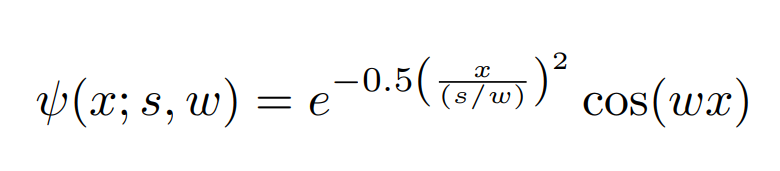

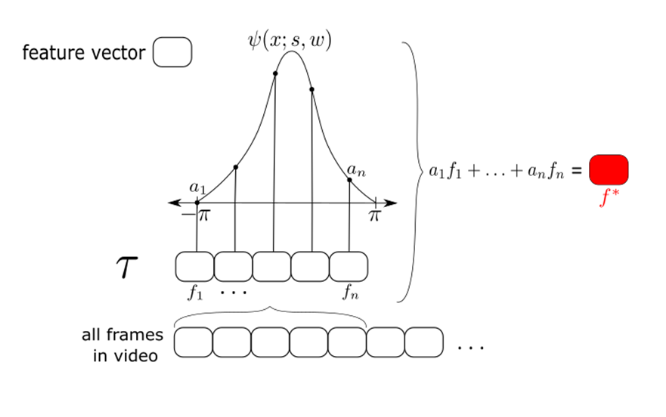

**Exerciese 8:** Do you observe anything common or different across program structures for the best and worst programs using the Morlet Filter? How does the performance compare to the base DSL?


**Solution to Exerciese 8:** (please write down your observation here)

In [ ]:
!yes | python train.py \
--algorithm enumeration \
--exp_name investigation_morlet \
--trial 1 \
--seed 1 \
--dsl_str "morlet" \
--train_data "data/calms21_task1/train_data.npy" \
--test_data "data/calms21_task1/test_data.npy" \
--valid_data "data/calms21_task1/val_data.npy" \
--train_labels "data/calms21_task1/train_investigation_labels.npy" \
--test_labels "data/calms21_task1/test_investigation_labels.npy" \
--valid_labels "data/calms21_task1/val_investigation_labels.npy" \
--input_type "list" \
--output_type "atom" \
--input_size 18 \
--output_size 1 \
--num_labels 1 \
--lossfxn "bcelogits" \
--learning_rate 0.0001 \
--symbolic_epochs 12 \
--max_num_programs 25 \
--class_weights "2.0"

Seed is 1
Experiment log and results saved at: results/investigation_morlet_enumeration_sd_1_001

DEBUG: starting enumerative synthesis with depth 1
DEBUG: 0 programs found
DEBUG: starting enumerative synthesis with depth 2
DEBUG: 8 programs found
DEBUG: starting enumerative synthesis with depth 3
DEBUG: 8 programs found
DEBUG: starting enumerative synthesis with depth 4
DEBUG: 8 programs found
DEBUG: starting enumerative synthesis with depth 5
DEBUG: 648 programs found
Symbolic Synthesis: generated 648/25 symbolic programs from candidate program.
Training candidate program (1/25) Start(MorletFilterOp(ResAngleHeadBodySelect()))
/content/drive/MyDrive/CS515HW2/code_and_data/near.py:222: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_input = [torch.tensor(traj) for traj i


# Enumeration with Neural Modules in DSL

So far, the base and Morlet filter DSLs we have used do not contain any neural modules. The code below trains neurosymbolic programs by using `DSL_DICT_NEUROSYM` from  `dsl.ipynb`. This DSL include `NeuralFeatureSelectionFunction`, which trains a fully connected neural network over the features. 

**Exercise 9:** How does the program found by enumeration compare to the previous ones using DSLs with feature selects? 

**Solution to Exercise 9:** (write your observation here)

In [ ]:
!yes | python train.py \
--algorithm enumeration \
--exp_name investigation_neurosym \
--trial 1 \
--seed 1 \
--dsl_str "neurosym" \
--train_data "data/calms21_task1/train_data.npy" \
--test_data "data/calms21_task1/test_data.npy" \
--valid_data "data/calms21_task1/val_data.npy" \
--train_labels "data/calms21_task1/train_investigation_labels.npy" \
--test_labels "data/calms21_task1/test_investigation_labels.npy" \
--valid_labels "data/calms21_task1/val_investigation_labels.npy" \
--input_type "list" \
--output_type "atom" \
--input_size 18 \
--output_size 1 \
--num_labels 1 \
--lossfxn "bcelogits" \
--learning_rate 0.0001 \
--symbolic_epochs 12 \
--max_num_programs 25 \
--class_weights "2.0"

Result program found in save path, overwrite log and program? [y/n]Seed is 1
Experiment log and results saved at: results/investigation_neurosym_enumeration_sd_1_001

DEBUG: starting enumerative synthesis with depth 1
DEBUG: 0 programs found
DEBUG: starting enumerative synthesis with depth 2
DEBUG: 9 programs found
DEBUG: starting enumerative synthesis with depth 3
DEBUG: 9 programs found
DEBUG: starting enumerative synthesis with depth 4
DEBUG: 9 programs found
DEBUG: starting enumerative synthesis with depth 5
DEBUG: 900 programs found
Symbolic Synthesis: generated 900/25 symbolic programs from candidate program.
Training candidate program (1/25) Start(MorletFilterOp(ResAngleHeadBodySelect()))
/content/drive/MyDrive/CS515HW2/code_and_data/near.py:222: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/util

# Visualizing Runtime vs. Classification Performance 

To evaluate your enumeration runs, we can take the saved log files in `code_and_data/results` and plot the total runtime against F1 score.

**Exercise 10**: Some hyperparameters that affect runtime and F1 score performance are listed below. Try changing a few of these and save their performance!

*   `max_num_programs` : maximum number of programs to optimize for enumeration
*   `symbolic_epochs` : the number of training epochs for updating program parameters
*   You can modify the search depth with `min_enum_depth` and `max_depth`. Note that if the depth is too large, enumerating through all the programs will take a long time. 

Also remember to update `exp_name` and `trial` to prevent overwriting previous runs.

**Solution to Exercise 10:** (Please list what hyperparameters you have changed and what's their effect).

In [ ]:
# Utility functions for visualizing run time vs accuracy

def parse_runtime_f1_from_logs(log_files):

  runtime = []
  f1 = []

  runtime_key = 'Total time elapsed is:'
  f1_key = 'F1 score achieved is'

  for item in log_files:
    # If there's a list of list of files corresponding to different random seeds,
    # we take the average
    if len(item[0]) > 1:
      seed_runtime = []
      seed_f1 = []
      for seed in item:
        with open(os.path.join('results', seed, 'log.txt')) as f:
            lines = f.readlines()

            curr_runtimes = []
            for line in lines:
              if runtime_key in line:
                curr_runtimes.append(float(line.split(runtime_key)[-1].strip()))
            
              if f1_key in line:
                seed_f1.append(float(line.split(f1_key)[-1].strip()))
            seed_runtime.append(curr_runtimes[-1])
      runtime.append(np.mean(seed_runtime))
      f1.append(np.mean(seed_f1))        
    else:
      # There's only 1 seed per run
      with open(os.path.join('results', item, 'log.txt')) as f:
        lines = f.readlines()

      curr_runtimes = []
      for line in lines:
        if runtime_key in line:
          curr_runtimes.append(float(line.split(runtime_key)[-1].strip()))
      
        if f1_key in line:
          f1.append(float(line.split(f1_key)[-1].strip()))
      runtime.append(curr_runtimes[-1])

  return runtime, f1

def plot_runtime_f1(runtime, f1, labels):
  assert(len(runtime) == len(f1) == len(labels))

  fig = plt.figure()
  for i, item in enumerate(labels):
    if len(item[0]) > 1:
      item = item[0]
    plt.scatter(runtime[i], f1[i], label = item.split('_sd')[0])

  plt.xlim([10, 400])
  plt.ylim([0.3, 0.75])  
  plt.xlabel("Runtime (s)")
  plt.ylabel("F1 score")  
  plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1 + 0.1*len(labels)))


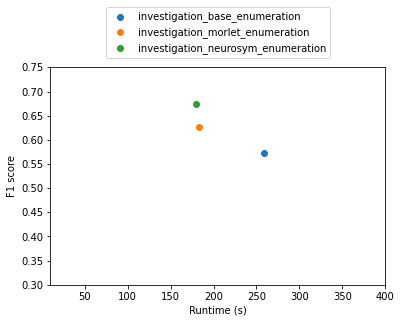

In [ ]:
# Directory names to plot inside near_code/results
run_names_to_plot = ['investigation_base_enumeration_sd_1_001', 
                     'investigation_morlet_enumeration_sd_1_001',
                     'investigation_neurosym_enumeration_sd_1_001']

runtime, f1 = parse_runtime_f1_from_logs(run_names_to_plot)

plot_runtime_f1(runtime, f1, run_names_to_plot)

**Note**: The code below will not work without running with seed = 2 for enumeration using the Morlet filter. 

We include an example of how to plot using multiple random seeds - the code will average over all entries in the list of lists.

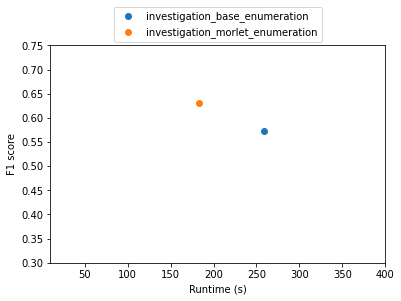

In [ ]:
# Example of plotting with multiple random seeds
# Directory names to plot inside near_code/results
run_names_to_plot = ['investigation_base_enumeration_sd_1_001', 
                     ['investigation_morlet_enumeration_sd_1_001',
                      'investigation_morlet_enumeration_sd_2_001']]

runtime, f1 = parse_runtime_f1_from_logs(run_names_to_plot)

plot_runtime_f1(runtime, f1, run_names_to_plot)

## Printing saved programs

You can use the example below to print your saved programs in `results`.

In [ ]:
import pickle
from near import print_program

# Change the program name here if you want to print other programs
saved_program = pickle.load(open('results/investigation_morlet_enumeration_sd_1_001/program.p', 'rb'))
print(print_program(saved_program, ignore_constants = False))

Start(MorletFilterOp(OverlapBboxesSelect(params: dict_values([Parameter containing:
tensor([[0.3289]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([0.2013], device='cuda:0', requires_grad=True)])), params: dict_values([tensor(0.4697, device='cuda:0', requires_grad=True), tensor(0.5294, device='cuda:0', requires_grad=True)])))


# Exercise 11: Implement your own temporal filter

We provide an implementation for the symmetric Morlet filter (filter shape is symmetric around time 0, the current frame), which you used earlier for enumeration. 

Implement `get_filter_default_xvals` for `AsymmetricFilterOp` in `dsl.ipynb` so that you can also use `AsymMorletFilterOp` in your DSL. You can use the `get_filter_default_xvals` in `SymmetricFilterOp` as a reference. The Asymmetric Morlet filter is similar to the symmetric one, except it has two sets of parameters for `s` and `w`, one for `left`, which corresponds to timestamps before the current time, and one for `right`, which corresponds to timestamps after the current time. The filter is thus asymmetrical with different filter shapes before and after the current time.

**Hint**: How should `get_filter_default_xvals` call `get_filter` to implement the asymmetry?

**Important**: after modifying `dsl.ipynb`, you will need to re-convert your new dsl to python files, included in the cell below.

Run enumeration with your new DSL with asymmetric Morlet filter in addition to the symmetric Morlet and record your results. What happened to the search space after adding your own filter? Was your filter found by enumeration and did it improve performance?

**Solution to Exercise 11:** (The answer to Exercise 11 consists of two parts: (1) Your implementation of assymetric Morlet filter (2) Answer to the two questions above.

In [ ]:
!jupyter nbconvert --to python dsl.ipynb
!jupyter nbconvert --to python near.ipynb

[NbConvertApp] Converting notebook dsl.ipynb to python
[NbConvertApp] Writing 41558 bytes to dsl.py
[NbConvertApp] Converting notebook near.ipynb to python
[NbConvertApp] Writing 39669 bytes to near.py


In [ ]:
!yes | python train.py \
--algorithm enumeration \
--exp_name investigation_asym_morlet \
--trial 1 \
--seed 1 \
--dsl_str "asym_morlet" \
--train_data "data/calms21_task1/train_data.npy" \
--test_data "data/calms21_task1/test_data.npy" \
--valid_data "data/calms21_task1/val_data.npy" \
--train_labels "data/calms21_task1/train_investigation_labels.npy" \
--test_labels "data/calms21_task1/test_investigation_labels.npy" \
--valid_labels "data/calms21_task1/val_investigation_labels.npy" \
--input_type "list" \
--output_type "atom" \
--input_size 18 \
--output_size 1 \
--num_labels 1 \
--lossfxn "bcelogits" \
--learning_rate 0.0001 \
--symbolic_epochs 12 \
--max_num_programs 25 \
--class_weights "2.0"

Seed is 1
Experiment log and results saved at: results/investigation_asym_morlet_enumeration_sd_1_001

DEBUG: starting enumerative synthesis with depth 1
DEBUG: 0 programs found
DEBUG: starting enumerative synthesis with depth 2
DEBUG: 8 programs found
DEBUG: starting enumerative synthesis with depth 3
DEBUG: 8 programs found
DEBUG: starting enumerative synthesis with depth 4
DEBUG: 8 programs found
DEBUG: starting enumerative synthesis with depth 5
DEBUG: 648 programs found
Symbolic Synthesis: generated 648/25 symbolic programs from candidate program.
Training candidate program (1/25) Start(AsymMorletFilterOp(ResAngleHeadBodySelect()))
/content/drive/MyDrive/Neurosymbolic_Summer_School_Tutorials/code_and_data/near.py:222: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_

Next, we will go over neurally-guided search to further improve the efficiency of program search. 



# Neural Relaxation Exercise 

[Admissible heuristics](https://en.wikipedia.org/wiki/Admissible_heuristic) are heuristics that never overestimate the cost of reaching a goal. These heuristics can be used as part of an informed search algorithm, such as [A* search](https://en.wikipedia.org/wiki/A*_search_algorithm). Here, we use the assumption that sufficiently large neural networks have greater representational power compared to neurosymbolic models or symbolic models, and use this neural relaxation as an admissible heuristic over the program graph search space.



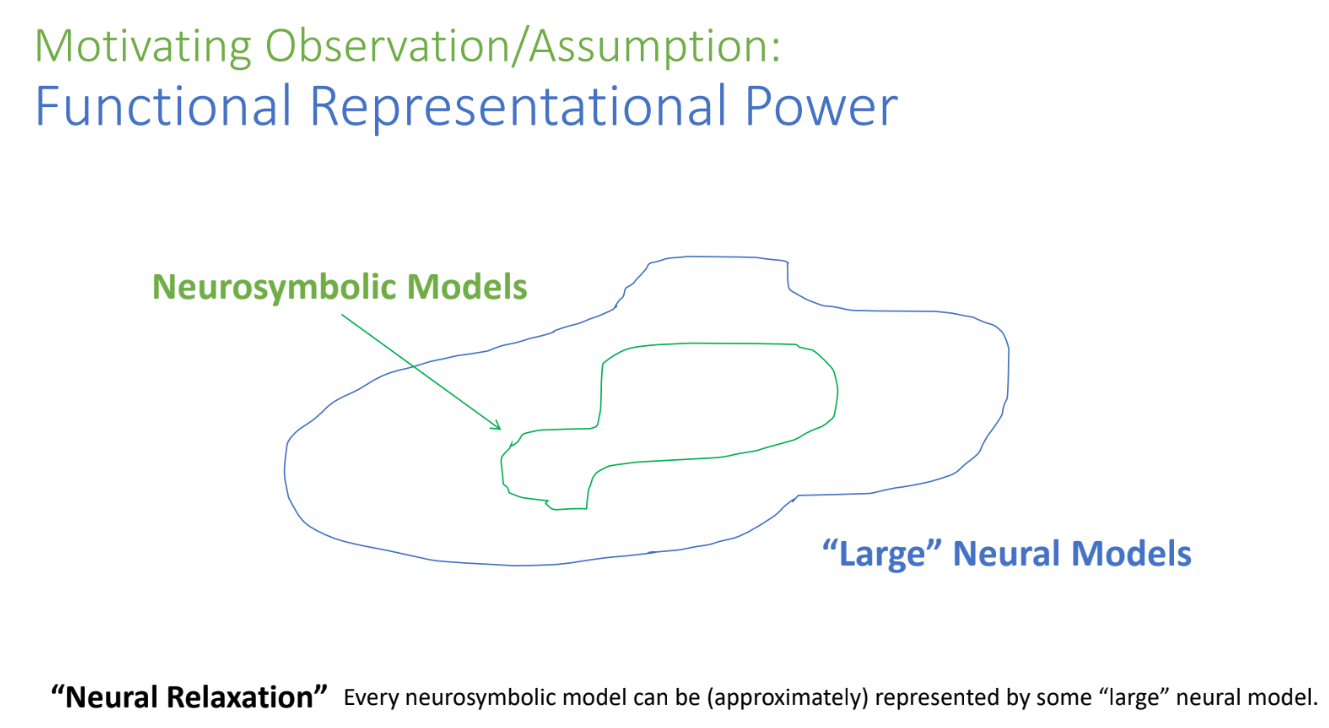

Run the utility code below to set up the training.

In [ ]:
!pip install pytorch-lightning==1.8.2 # Pytorch lightning is a wrapper around PyTorch.
import os
import torch, numpy as np
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from sklearn.metrics import f1_score, precision_score, recall_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Utility Functions copied from before

class TrainConfig:
    epochs: int = 20
    batch_size: int = 32
    lr: float = 3e-3
    weight_decay: float = 0.0
    train_size: int = 2000 # out of 5000
    val_size: int = 1000 # out of 5000
    test_size: int = 3000 # out of 3000
    num_classes: int = 2

config = TrainConfig()

# Dataloader for the CalMS21 dataset
class Calms21Task1Dataset(torch.utils.data.Dataset):
    def __init__(self, data_path, investigations_path, transform=None, target_transform=None):
        self.data = np.load(data_path)
        self.investigations = np.load(investigations_path)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.investigations[idx]
        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            y = self.target_transform(y)
        return x, y


class Calms21Task1DataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size, transform=None, target_transform=None ):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.train_data_path = os.path.join(data_dir, "train_data.npy")
        self.train_investigations_path = os.path.join(data_dir, "train_investigation_labels.npy")
        self.test_data_path = os.path.join(data_dir, "test_data.npy")
        self.test_investigations_path = os.path.join(data_dir, "test_investigation_labels.npy")
        self.val_data_path = os.path.join(data_dir, "val_data.npy")
        self.val_investigations_path = os.path.join(data_dir, "val_investigation_labels.npy")
        self.transform = transform
        self.target_transform = target_transform

    def setup(self, stage=None):
        self.train_dataset = Calms21Task1Dataset(self.train_data_path, self.train_investigations_path, self.transform, self.target_transform)
        self.val_dataset = Calms21Task1Dataset(self.val_data_path, self.val_investigations_path, self.transform, self.target_transform)
        self.test_dataset = Calms21Task1Dataset(self.test_data_path, self.test_investigations_path, self.transform, self.target_transform)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
    
    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)
    
    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)

dm = Calms21Task1DataModule(data_dir="data/calms21_task1/", batch_size=32, transform=None, target_transform=None)
dm.setup(None)

def train(model, datamodule, config):
    trainer = pl.Trainer(gpus=0, max_epochs=config.epochs)
    trainer.fit(model, datamodule)
    return model

# Evaluate using F1 score.
test_labels = np.load("data/calms21_task1/test_investigation_labels.npy")

def evaluate(model, data_loader, gt_labels):
  predictions = []
  for x,_ in data_loader:
    predictions.append(torch.argmax(model(x), dim = -1))

  predictions = torch.cat(predictions, dim = 0)

  f1 = f1_score(test_labels, predictions, average="binary")
  precision = precision_score(test_labels, predictions, average="binary")
  recall = recall_score(test_labels, predictions, average="binary")

  print("F1 score on test set: " + str(f1))
  print("Precision on test set: " + str(precision))
  print("Recall on test set: " + str(recall))

  return predictions, f1, precision, recall

**Exercise 12**: The cost of a program is represented by structural cost + the model performance (error in F1 score). Use the 2 code cells below to compare performance between: 

*    Program 1: `Window13Avg( Or(MinResNoseKeypointDistSelect,AccelerationSelect) )` 
*    Program 2: `Window13Avg( Or(AtomToAtomModule,AtomToAtomModule) )` 

Which program have lower cost in terms of error in F1 score? `AtomToAtomModule` from program 2 are neural networks, while `MinResNoseKeypointDistSelect` and `AccelerationSelect` from program 1 are feature selects with only a small set of weights and bias that are learned. Are you able to find features in `DSL_DICT` in `dsl.ipynb` that enables program 1 to perform better than program 2?

**Solution to Exercise 12:** (List the performance for each program and your findings)

## Example of a symbolic program

In [ ]:
# Complete program
from dsl_compiler import ExpertProgram

program = "Window13Avg( Or(MinResNoseKeypointDistSelect,AccelerationSelect) )"
config.lr = 1e-2
sample_model = ExpertProgram(program, config=config)

# Use gradient descent to find parameters of multi-variable linear regression.
sample_model = train(sample_model, dm, config=config)

predictions_symbolic, _, _, _ = evaluate(sample_model, dm.test_dataloader(), test_labels)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/setup.py:178: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type | Params
-----------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


F1 score on test set: 0.6102897693672383
Precision on test set: 0.5314109165808445
Recall on test set: 0.7166666666666667


## Example of a Neurosymbolic Program

In [ ]:
# Neurosymbolic
program = "Window13Avg( Or(AtomToAtomModule,AtomToAtomModule) )"
config.lr = 1e-2
sample_model = ExpertProgram(program, config=config)

# Use gradient descent to find parameters of multi-variable linear regression.
sample_model = train(sample_model, dm, config=config)

predictions_symbolic, _, _, _ = evaluate(sample_model, dm.test_dataloader(), test_labels)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/setup.py:178: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type | Params
-----------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


F1 score on test set: 0.7385229540918165
Precision on test set: 0.7088122605363985
Recall on test set: 0.7708333333333334


## Example of a Neural Module

How does the performance compare to the neurosymbolic program and the symbolic program?

In [ ]:
# This is an RNN = basically fully neural. How does the error compare?
program = "ListToAtomModule"
config.lr = 1e-2
sample_model = ExpertProgram(program, config=config)

# Use gradient descent to find parameters of multi-variable linear regression.
sample_model = train(sample_model, dm, config=config)

predictions_symbolic, _, _, _ = evaluate(sample_model, dm.test_dataloader(), test_labels)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/setup.py:178: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type | Params
-----------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


F1 score on test set: 0.7649402390438247
Precision on test set: 0.732824427480916
Recall on test set: 0.8


# NEAR: Astar Search

We can use NEAR as a heuristic to guide A* search. We maintain a frontier of nodes (starting with an empty program), and at each iteration we choose a node on the frontier to explore by using the NEAR heuristic with a structural cost to estimate its path cost. The search terminates when the frontier is empty, after which we return the best complete program found during our search.

## NEAR with Base DSL

**Exercise 13:** How does the programs found by NEAR differ from enumeration through the search process? How does the frontier size change during the search process?

**Solution to Exercise 13:** (write your answer here)

In [ ]:
!yes| python train.py \
--algorithm astar-near \
--exp_name investigation_base \
--trial 1 \
--seed 1 \
--dsl_str "default" \
--train_data "data/calms21_task1/train_data.npy" \
--test_data "data/calms21_task1/test_data.npy" \
--valid_data "data/calms21_task1/val_data.npy" \
--train_labels "data/calms21_task1/train_investigation_labels.npy" \
--test_labels "data/calms21_task1/test_investigation_labels.npy" \
--valid_labels "data/calms21_task1/val_investigation_labels.npy" \
--input_type "list" \
--output_type "atom" \
--input_size 18 \
--output_size 1 \
--num_labels 1 \
--lossfxn "bcelogits" \
--frontier_capacity 8 \
--max_num_children 10 \
--max_depth 5 \
--max_num_units 32 \
--min_num_units 16 \
--learning_rate 0.0001 \
--neural_epochs 4 \
--symbolic_epochs 12 \
--class_weights "2.0"

Seed is 1
Experiment log and results saved at: results/investigation_base_astar-near_sd_1_001

Training root program ...
/content/drive/MyDrive/CS515HW2/code_and_data/near.py:222: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_input = [torch.tensor(traj) for traj in batch]
Initial training complete. F1-Score from program is 0.5791 

CURRENT program has depth 0, fscore inf: Start(ListToAtomModule)
Training child program: Start(Or(ListToAtomModule, ListToAtomModule))
DEBUG: f-score 0.3788709677419355
Training child program: Start(And(ListToAtomModule, ListToAtomModule))
DEBUG: f-score 0.562713567839196
Training child program: Start(Window5Avg(AtomToAtomModule))
DEBUG: f-score 0.9176923076923077
Frontier length is: 3
Total time elapsed is 10.544

CURRENT program has depth 

## NEAR with Morlet DSL

**Exercise 14:** How does the programs found by NEAR using the Morlet filter differ from enumeration through the search process? How does the program performance differ from the default DSL?

**Solution to Exercise 14:** (write your answer here)

In [ ]:
!yes| python train.py \
--algorithm astar-near \
--exp_name investigation_morlet \
--trial 1 \
--seed 1 \
--dsl_str "morlet" \
--train_data "data/calms21_task1/train_data.npy" \
--test_data "data/calms21_task1/test_data.npy" \
--valid_data "data/calms21_task1/val_data.npy" \
--train_labels "data/calms21_task1/train_investigation_labels.npy" \
--test_labels "data/calms21_task1/test_investigation_labels.npy" \
--valid_labels "data/calms21_task1/val_investigation_labels.npy" \
--input_type "list" \
--output_type "atom" \
--input_size 18 \
--output_size 1 \
--num_labels 1 \
--lossfxn "bcelogits" \
--frontier_capacity 8 \
--max_num_children 10 \
--max_depth 5 \
--max_num_units 32 \
--min_num_units 16 \
--learning_rate 0.0001 \
--neural_epochs 4 \
--symbolic_epochs 12 \
--class_weights "2.0"


Result program found in save path, overwrite log and program? [y/n]Seed is 1
Experiment log and results saved at: results/investigation_morlet_astar-near_sd_1_001

Training root program ...
/content/drive/MyDrive/CS515HW2/code_and_data/near.py:222: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_input = [torch.tensor(traj) for traj in batch]
Initial training complete. F1-Score from program is 0.5791 

CURRENT program has depth 0, fscore inf: Start(ListToAtomModule)
Training child program: Start(Or(ListToAtomModule, ListToAtomModule))
DEBUG: f-score 0.3788709677419355
Training child program: Start(And(ListToAtomModule, ListToAtomModule))
DEBUG: f-score 0.562713567839196
Training child program: Start(MorletFilterOp(AtomToAtomModule))
DEBUG: f-score 0.5946560846560847
Front

# Visualizing Runtime vs. Accuracy 

To evaluate your NEAR runs, we can take the saved log files in `code_and_data/results` and plot the total runtime against accuracy.

**Exercise 15**: Some hyperparameters that affect runtime and accuracy are listed below. Try changing 2 of these and write down the performance.

*   `neural_epochs`: number of epochs to train the neural network approximator
*   `min_num_units` and `max_num_units`: minimum and maximum number of units in the neural network. The network is smaller as the search gets deeper.
*    `max_num_children`: max number of children for a node
*    `frontier_capacity`: capacity of frontier maintained by the search algorithm

How does the runtime and performance of NEAR compare to enumeration (Use the code cell below to get a graph comparing NEAR to enumeration)?

**Solution to Exercise 15**: (Write what hyperparameters you have tried and the comparison between NEAR and enumeration)

In [ ]:
# Plotting utility functions

def parse_runtime_f1_from_logs(log_files):

  runtime = []
  f1 = []

  runtime_key = 'Total time elapsed is'
  f1_key = 'F1 score achieved is'

  for item in log_files:
    # If there's a list of list of files corresponding to different random seeds,
    # we take the average
    if len(item[0]) > 1:
      seed_runtime = []
      seed_f1 = []
      for seed in item:
        with open(os.path.join('results', seed, 'log.txt')) as f:
            lines = f.readlines()

            curr_runtimes = []
            for line in lines:
              if runtime_key in line:
                if line.split(runtime_key)[-1].startswith(':'):
                  curr_runtimes.append(float(line.split(runtime_key)[-1].strip()[1:]))
                else:
                  curr_runtimes.append(float(line.split(runtime_key)[-1].strip()))
            
              if f1_key in line:
                seed_f1.append(float(line.split(f1_key)[-1].strip()))
            seed_runtime.append(curr_runtimes[-1])
      runtime.append(np.mean(seed_runtime))
      f1.append(np.mean(seed_f1))        
    else:
      # There's only 1 seed per run
      with open(os.path.join('results', item, 'log.txt')) as f:
        lines = f.readlines()

      curr_runtimes = []
      for line in lines:
        if runtime_key in line:
            if line.split(runtime_key)[-1].startswith(':'):
              curr_runtimes.append(float(line.split(runtime_key)[-1].strip()[1:]))
            else:
              curr_runtimes.append(float(line.split(runtime_key)[-1].strip()))
      
        if f1_key in line:
          f1.append(float(line.split(f1_key)[-1].strip()))
      runtime.append(curr_runtimes[-1])

  return runtime, f1

def plot_runtime_f1(runtime, f1, labels):
  assert(len(runtime) == len(f1) == len(labels))

  fig = plt.figure()
  for i, item in enumerate(labels):
    if len(item[0]) > 1:
      item = item[0]
    plt.scatter(runtime[i], f1[i], label = item.split('_sd')[0])

  plt.xlim([10, 400])
  plt.ylim([0.3, 0.75])  
  plt.xlabel("Runtime (s)")
  plt.ylabel("F1 score")    
  plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1 + 0.1*len(labels)))


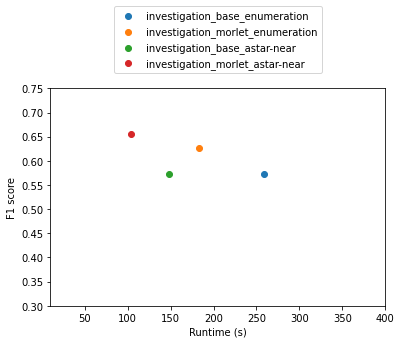

In [ ]:
# Directory names to plot inside near_code/results
run_names_to_plot = ['investigation_base_enumeration_sd_1_001', 
                     'investigation_morlet_enumeration_sd_1_001',
                     'investigation_base_astar-near_sd_1_001',
                     'investigation_morlet_astar-near_sd_1_001']

runtime, f1 = parse_runtime_f1_from_logs(run_names_to_plot)

plot_runtime_f1(runtime, f1, run_names_to_plot)

# Exercise 16: Open-Ended Exploration

Can you improve the performance of neurally-guided program search? Feel free to make any changes to the code! Below are some suggestions:

*   Modifying neural heuristic: looking at the neural modules in `dsl.ipynb`, such as `ListToAtomModule` or `AtomToAtomModule` and the hyperparameters for training the neural approximators, are you able to improve the neural heuristic we currently use? The ideal neural heuristic would be able to be trained quickly, while approximating the program performance closely and is admissible. 
*   Modify search space: are there any modifications you can make to the search space, for example, through modifying the DSL or min/max program depth that leads to better runtime and performance?

**Solution to Exercise 16:** (please describe what you have tried to improve the performance and what's the effect of your change)

# Exercise 17: Modify Architecture of AtomToAtom Heuristic

In `dsl.ipynb`, the architecture of the neural heuristics used are defined in the Section called Neural Functions. In this section, the `AtomToAtomModule` in `dsl.ipynb` uses a 2-layer network in `FeedForwardModule` as the neural approximator. Modify the network architecture to add a third layer and run NEAR below. Do you observe any changes in performance? Why or why not?

**Solution to Exercise 17:** (please write down your observation)

**Important**: after modifying `dsl.ipynb`, you will need to re-convert your new dsl to python files, included in the cell below.


In [ ]:
!jupyter nbconvert --to python dsl.ipynb
!jupyter nbconvert --to python near.ipynb

In [ ]:
!yes| python train.py \
--algorithm astar-near \
--exp_name investigation_morlet_3layer \
--trial 1 \
--seed 1 \
--dsl_str "morlet" \
--train_data "data/calms21_task1/train_data.npy" \
--test_data "data/calms21_task1/test_data.npy" \
--valid_data "data/calms21_task1/val_data.npy" \
--train_labels "data/calms21_task1/train_investigation_labels.npy" \
--test_labels "data/calms21_task1/test_investigation_labels.npy" \
--valid_labels "data/calms21_task1/val_investigation_labels.npy" \
--input_type "list" \
--output_type "atom" \
--input_size 18 \
--output_size 1 \
--num_labels 1 \
--lossfxn "bcelogits" \
--frontier_capacity 8 \
--max_num_children 10 \
--max_depth 5 \
--max_num_units 16 \
--min_num_units 8 \
--learning_rate 0.0001 \
--neural_epochs 4 \
--symbolic_epochs 12 \
--class_weights "2.0"

Result program found in save path, overwrite log and program? [y/n]Seed is 1
Experiment log and results saved at: results/investigation_morlet_3layer_astar-near_sd_1_001

Training root program ...
/content/drive/MyDrive/neurosymbolic_summer_school_notebooks/code_sketch/near_code/near.py:219: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  batch_input = [torch.tensor(traj) for traj in batch]
Initial training complete. F1-Score from program is 0.1141 

CURRENT program has depth 0, fscore inf: Start(ListToAtomModule)
Training child program: Start(Or(ListToAtomModule, ListToAtomModule))
DEBUG: f-score 0.7521428571428572
Training child program: Start(And(ListToAtomModule, ListToAtomModule))
DEBUG: f-score 0.9096103896103896
Training child program: Start(MorletFilterOp(AtomToAtomMod

# Exercise 18: NEAR: IDDFS Search - Morlet DSL

The admissible heuristics used by NEAR is compatible with different search strategies - here, we use [iterative deepening depth-first search](https://en.wikipedia.org/wiki/Iterative_deepening_depth-first_search) (IDDFS) instead of A* search through the program space. IDDFS is a search strategy where depth-limited version of depth-first search is run repreatedly with increasing depth limits.

How does the performance of IDDFS compare to A* on this dataset?

**Solution to Exercise 18:** (please write down your observation)


In [ ]:
!yes| python train.py \
--algorithm iddfs-near \
--exp_name investigation_morlet \
--trial 1 \
--seed 1 \
--dsl_str "morlet" \
--train_data "data/calms21_task1/train_data.npy" \
--test_data "data/calms21_task1/test_data.npy" \
--valid_data "data/calms21_task1/val_data.npy" \
--train_labels "data/calms21_task1/train_investigation_labels.npy" \
--test_labels "data/calms21_task1/test_investigation_labels.npy" \
--valid_labels "data/calms21_task1/val_investigation_labels.npy" \
--input_type "list" \
--output_type "atom" \
--input_size 18 \
--output_size 1 \
--num_labels 1 \
--lossfxn "bcelogits" \
--frontier_capacity 5 \
--max_num_children 10 \
--max_depth 5 \
--max_num_units 16 \
--min_num_units 8 \
--learning_rate 0.0001 \
--neural_epochs 4 \
--symbolic_epochs 12 \
--class_weights "2.0"

Result program found in save path, overwrite log and program? [y/n]Seed is 1
Experiment log and results saved at: results/investigation_morlet_iddfs-near_sd_1_001

Training root program ...
/content/drive/MyDrive/CS515HW2/code_and_data/near.py:222: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_input = [torch.tensor(traj) for traj in batch]
Initial training complete. Score from program is 0.1141 

CURRENT program has depth 0, fscore inf: Start(ListToAtomModule)
Frontier length is: 0
Frontier length is now 0
Empty frontier, moving to next depth level
DEBUG: time since start is 10.492

Starting iterative deepening with depth 2

CURRENT program has depth 1, fscore 0.4796: Start(MorletFilterOp(AtomToAtomModule))
New BEST program found:
Start(MorletFilterOp(ResAngleHeadBodyS

# Exercise 19: Additional Experiments: Test on Other Behavior Classes

In behavior analysis, animals exhibit a wide range of behaviors, and the goal of behavioral neuroscience is to learn the neural basis of these behaviors. Investigation vs. no investigation is one example of a human-defined behavior, but there's also behaviors such as mount, attack, rearing, approach, groom, ...

Here, we provide an additional set of behavior annotations for mount. How does the DSL and algorithm you developed compare to using enumeration as a baseline for program search? Mount is a relatively rare class compared to investigation - how do the performances compare? Run the 2 code cells below and report any finding.

**Solution to Exercise 19:** (please write down your findings)

In [ ]:
!yes | python train.py \
--algorithm enumeration \
--exp_name investigation_morlet \
--trial 1 \
--seed 1 \
--dsl_str "morlet" \
--train_data "data/calms21_task1/train_data.npy" \
--test_data "data/calms21_task1/test_data.npy" \
--valid_data "data/calms21_task1/val_data.npy" \
--train_labels "data/calms21_task1/train_mount_labels.npy" \
--test_labels "data/calms21_task1/test_mount_labels.npy" \
--valid_labels "data/calms21_task1/val_mount_labels.npy" \
--input_type "list" \
--output_type "atom" \
--input_size 18 \
--output_size 1 \
--num_labels 1 \
--lossfxn "bcelogits" \
--learning_rate 0.0001 \
--symbolic_epochs 12 \
--max_num_programs 25 \
--class_weights "2.0"

Result program found in save path, overwrite log and program? [y/n]Seed is 1
Experiment log and results saved at: results/investigation_morlet_enumeration_sd_1_001

DEBUG: starting enumerative synthesis with depth 1
DEBUG: 0 programs found
DEBUG: starting enumerative synthesis with depth 2
DEBUG: 8 programs found
DEBUG: starting enumerative synthesis with depth 3
DEBUG: 8 programs found
DEBUG: starting enumerative synthesis with depth 4
DEBUG: 8 programs found
DEBUG: starting enumerative synthesis with depth 5
DEBUG: 648 programs found
Symbolic Synthesis: generated 648/25 symbolic programs from candidate program.
Training candidate program (1/25) Start(MorletFilterOp(ResAngleHeadBodySelect()))
/content/drive/MyDrive/CS515HW2/code_and_data/near.py:222: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/

In [ ]:
!yes| python train.py \
--algorithm astar-near \
--exp_name investigation_morlet \
--trial 1 \
--seed 1 \
--dsl_str "morlet" \
--train_data "data/calms21_task1/train_data.npy" \
--test_data "data/calms21_task1/test_data.npy" \
--valid_data "data/calms21_task1/val_data.npy" \
--train_labels "data/calms21_task1/train_mount_labels.npy" \
--test_labels "data/calms21_task1/test_mount_labels.npy" \
--valid_labels "data/calms21_task1/val_mount_labels.npy" \
--input_type "list" \
--output_type "atom" \
--input_size 18 \
--output_size 1 \
--num_labels 1 \
--lossfxn "bcelogits" \
--frontier_capacity 8 \
--max_num_children 10 \
--max_depth 5 \
--max_num_units 32 \
--min_num_units 16 \
--learning_rate 0.0001 \
--neural_epochs 4 \
--symbolic_epochs 12 \
--class_weights "2.0"


Result program found in save path, overwrite log and program? [y/n]Seed is 1
Experiment log and results saved at: results/investigation_morlet_astar-near_sd_1_001

Training root program ...
/content/drive/MyDrive/CS515HW2/code_and_data/near.py:222: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  batch_input = [torch.tensor(traj) for traj in batch]
Initial training complete. F1-Score from program is 0.3256 

CURRENT program has depth 0, fscore inf: Start(ListToAtomModule)
Training child program: Start(Or(ListToAtomModule, ListToAtomModule))
DEBUG: f-score 0.5621686746987951
Training child program: Start(And(ListToAtomModule, ListToAtomModule))
DEBUG: f-score 1.02
Training child program: Start(MorletFilterOp(AtomToAtomModule))
DEBUG: f-score 0.5433333333333333
Frontier length is

**Acknowledgements**: This notebook and other notebooks used in this project are adapted from the neuralsymbolic programming toturial for the neurosymbolic summer school. This notebook was originally developed by Jennifer J. Sun  (Caltech) and Atharva Sengal (UT Austin). The data subset is processed from CalMS21 and the DSL is developed by by Megan Tjandrasuwita (MIT) from her work on [Interpreting Expert Annotation Differences in Animal Behavior](https://arxiv.org/pdf/2106.06114.pdf). Megan's work is partly based on [NEAR](https://github.com/trishullab/near/tree/master/near_code) by Ameesh Shah (Berkeley) and Eric Zhan (Argo).